In [3]:
pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [5]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [6]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
     

100%|████████████████████████████| 9912422/9912422 [00:02<00:00, 4150292.76it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 7309660.50it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 2513196.27it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 4710813.25it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [15]:
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [16]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.to(device)

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [17]:
import time

n_epochs = 200  # 학습의 횟수(epoch) 설정
sample_interval = 2000  # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.FloatTensor(imgs.size(0), 1).fill_(1.0).to(device)  # 진짜(real): 1
        fake = torch.FloatTensor(imgs.size(0), 1).fill_(0.0).to(device)  # 가짜(fake): 0

        real_imgs = imgs.to(device)

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).to(device)

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


[Epoch 0/200] [D loss: 0.630109] [G loss: 1.249236] [Elapsed time: 12.21s]
[Epoch 1/200] [D loss: 0.545815] [G loss: 1.076102] [Elapsed time: 20.23s]
[Epoch 2/200] [D loss: 0.305982] [G loss: 1.025658] [Elapsed time: 28.42s]
[Epoch 3/200] [D loss: 0.478528] [G loss: 0.579132] [Elapsed time: 36.63s]
[Epoch 4/200] [D loss: 0.386330] [G loss: 0.832298] [Elapsed time: 45.05s]
[Epoch 5/200] [D loss: 0.434137] [G loss: 2.870917] [Elapsed time: 53.17s]
[Epoch 6/200] [D loss: 0.321214] [G loss: 0.953051] [Elapsed time: 61.49s]
[Epoch 7/200] [D loss: 0.188765] [G loss: 1.331848] [Elapsed time: 69.62s]
[Epoch 8/200] [D loss: 0.254302] [G loss: 1.236022] [Elapsed time: 77.84s]
[Epoch 9/200] [D loss: 0.258140] [G loss: 1.361077] [Elapsed time: 85.76s]
[Epoch 10/200] [D loss: 0.204036] [G loss: 2.583366] [Elapsed time: 93.71s]
[Epoch 11/200] [D loss: 0.309825] [G loss: 1.095897] [Elapsed time: 101.64s]
[Epoch 12/200] [D loss: 0.181582] [G loss: 1.764064] [Elapsed time: 109.77s]
[Epoch 13/200] [D lo

[Epoch 107/200] [D loss: 0.224929] [G loss: 2.259154] [Elapsed time: 901.59s]
[Epoch 108/200] [D loss: 0.329900] [G loss: 1.920098] [Elapsed time: 909.94s]
[Epoch 109/200] [D loss: 0.292466] [G loss: 1.181937] [Elapsed time: 918.25s]
[Epoch 110/200] [D loss: 0.335024] [G loss: 1.939206] [Elapsed time: 926.79s]
[Epoch 111/200] [D loss: 0.469636] [G loss: 3.519114] [Elapsed time: 935.27s]
[Epoch 112/200] [D loss: 0.258243] [G loss: 2.807069] [Elapsed time: 943.59s]
[Epoch 113/200] [D loss: 0.390385] [G loss: 1.171601] [Elapsed time: 951.90s]
[Epoch 114/200] [D loss: 0.339822] [G loss: 1.212846] [Elapsed time: 960.25s]
[Epoch 115/200] [D loss: 0.273361] [G loss: 1.599230] [Elapsed time: 968.59s]
[Epoch 116/200] [D loss: 0.302177] [G loss: 1.768785] [Elapsed time: 977.02s]
[Epoch 117/200] [D loss: 0.318431] [G loss: 2.230555] [Elapsed time: 985.37s]
[Epoch 118/200] [D loss: 0.296209] [G loss: 2.286486] [Elapsed time: 993.98s]
[Epoch 119/200] [D loss: 0.294064] [G loss: 4.696929] [Elapsed t

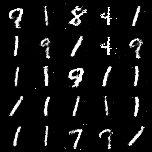

In [18]:
from IPython.display import Image

Image('92000.png')